In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

import scipy

# будем отображать графики прямо в jupyter'e
%pylab inline

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv("training_data.csv")

In [3]:
data['Score']=data['Score']+1
# поражение 1, ничья 1.5 победа 2

In [4]:
data=data.rename(index=str, columns={"Month #": "m", "White Player #": "w", "Black Player #": "b", "Score": "s"})

In [5]:
data.head(3)

,m,w,b,s
0,1,73,1246,1.5
1,1,73,5097,1.5
2,1,73,5104,1.5


In [6]:
tr, tst=train_test_split(data.values,test_size=0.3,
random_state=17)
#разделили выборку на обучение и тест

In [7]:
ds=pd.DataFrame(tr, columns=data.columns)
f=pd.DataFrame(tst, columns=data.columns)
# записали в смежные датафреймы тренировку и тест
x=f[['m', 'w', 'b']]
y=f['s']
# разделили тест на фичи и результат

In [8]:
ds.describe()

,m,w,b,s
count,45537.000000,45537.000000,45537.000000,45537.000000
mean,61.550388,4367.526868,4343.243714,1.546314
std,31.826493,2496.925468,2498.927717,0.371494
min,1.000000,1.000000,1.000000,1.000000
25%,35.000000,2155.000000,2124.000000,1.500000
50%,67.000000,4435.000000,4394.000000,1.500000
75%,93.000000,6554.000000,6514.000000,2.000000
max,100.000000,8631.000000,8631.000000,2.000000


In [9]:
f.describe()

,m,w,b,s
count,19516.000000,19516.000000,19516.000000,19516.000000
mean,61.561642,4348.190203,4342.763835,1.544092
std,31.893540,2491.979205,2484.869720,0.370360
min,1.000000,1.000000,1.000000,1.000000
25%,34.000000,2106.000000,2129.000000,1.500000
50%,67.000000,4422.000000,4399.000000,1.500000
75%,93.000000,6525.500000,6474.000000,2.000000
max,100.000000,8631.000000,8631.000000,2.000000


In [10]:
w=ds.groupby(['w'])['s'].agg([np.sum, np.mean, np.count_nonzero])
# сгруппировали партии по игрокам, играющими белыми: сумма очков, среднее, число игр
w=w.reset_index()
w=w.rename(index=str, columns={"w": "id", "sum": "sum_w", "mean": "mean_w", "count_nonzero": "games_w"})
w['id']=w['id'].astype('Int64')
b=ds.groupby(['b'])['s'].agg([np.sum, np.mean, np.count_nonzero])
# аналогично для чёрных
b=b.reset_index()
b=b.rename(index=str, columns={"b": "id", "sum": "sum_b", "mean": "mean_b", "count_nonzero": "games_b"})
b['id']=b['id'].astype('Int64')
r=pd.merge(w, b, how = 'left', left_on='id', right_on='id')
r=r.fillna(0)
# собрали оба цвета в одной таблице
# из таблицы пропали те, кто не сыграл ни одной игры белыми
r['sum_tot']=r['sum_w']+r['sum_b']
r['games_tot']=r['games_w']+r['games_b']

In [11]:
r.head(4)

,id,sum_w,mean_w,games_w,sum_b,mean_b,games_b,sum_tot,games_tot
0,1,34.0,1.789474,19.0,24.0,1.714286,14.0,58.0,33.0
1,3,3.0,1.500000,2.0,8.0,1.600000,5.0,11.0,7.0
2,4,19.0,1.461538,13.0,27.0,1.500000,18.0,46.0,31.0
3,5,6.5,1.300000,5.0,8.0,1.600000,5.0,14.5,10.0


In [12]:
r.describe()

,id,sum_w,mean_w,games_w,sum_b,mean_b,games_b,sum_tot,games_tot
count,6125.000000,6125.000000,6125.000000,6125.000000,6125.000000,6125.000000,6125.000000,6125.000000,6125.000000
mean,4328.120816,11.496245,1.473201,7.434612,11.154612,1.379251,7.228571,22.650857,14.663184
std,2491.531328,17.655241,0.260798,10.840804,16.147265,0.593803,10.873133,33.338522,21.453214
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2158.000000,2.000000,1.333333,2.000000,2.000000,1.388889,1.000000,4.500000,3.000000
50%,4333.000000,5.000000,1.500000,3.000000,5.500000,1.500000,3.000000,10.500000,7.000000
75%,6469.000000,12.500000,1.625000,8.000000,13.000000,1.714286,8.000000,25.500000,17.000000
max,8631.000000,174.000000,2.000000,105.000000,147.000000,2.000000,98.000000,320.500000,198.000000


In [13]:
# Метрики качества
def comp(f,y):
    return np.sum((abs(y - f['s'] )**2)/(max(abs(y - f['s'] )**2)))
# Квадратичное отколнение по всей дистанции, отнесённое к максимумальному несовпадению

def corr(f,y):
    return scipy.stats.pearsonr(y, f['s'])[0]
# Корреляция Пирсона

In [14]:
# Подготовка данных закончена. Поехали строить модели

In [15]:
# Нулевая модель. Результат каждой партии - рандом.
n=int(len(y))
rnd=np.random.rand(n,1)
rnd=(((np.round((rnd*100)%2,0)))/2)+1
rnd
r0=pd.DataFrame(rnd, columns=['s'])

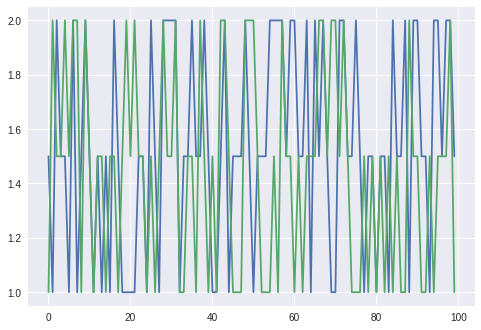

In [16]:
pl=100
plot(range(pl), r0['s'][0:pl], range(pl), y[0:pl])

In [17]:
comp(r0, y)

5157.0

In [18]:
corr(r0,y)

0.0025525857634356467

In [19]:
# рандом ожидаемо плох

In [20]:
# Первая простейшая модель. Рейтинг - среднее число набранных очков. Цвет не важен. 
# Тот, у кого выше рейтинг, всегда победит
r1=r
r1['rat']=r['sum_tot']/r['games_tot']
r1=r1.fillna(0)

In [21]:
r.head(5)

,id,sum_w,mean_w,games_w,sum_b,mean_b,games_b,sum_tot,games_tot,rat
0,1,34.0,1.789474,19.0,24.0,1.714286,14.0,58.0,33.0,1.757576
1,3,3.0,1.500000,2.0,8.0,1.600000,5.0,11.0,7.0,1.571429
2,4,19.0,1.461538,13.0,27.0,1.500000,18.0,46.0,31.0,1.483871
3,5,6.5,1.300000,5.0,8.0,1.600000,5.0,14.5,10.0,1.450000
4,6,3.5,1.750000,2.0,12.5,1.562500,8.0,16.0,10.0,1.600000


In [22]:
x.head(3)

,m,w,b
0,34.0,1200.0,4432.0
1,9.0,3824.0,8299.0
2,69.0,172.0,6578.0
